In [26]:
import importlib
from __imports__ import *
import data, LSTM_returns, optimization
importlib.reload(data)

<module 'data' from 'c:\\Users\\27904\\OneDrive\\桌面\\crypto\\AAA_Thursday1\\data\\__init__.py'>

In [27]:
df = data.load_asset('SOLUSDT', sampling='1d')
df = data.add_fear_and_greed(df)
# Restrict data after 2022
df = df[df.index >= '2024-01-01']
df

,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Taker buy base asset volume,Taker buy quote asset volume,F&G,F&G category
Open time,,,,,,,,,,,
2024-01-01,101.72,109.93,101.44,109.91,4.403310e+06,4.647638e+08,563530,2246699.810,2.372047e+08,65.0,Greed
2024-01-02,109.93,116.95,106.02,106.73,7.831366e+06,8.727018e+08,1029366,4008477.700,4.468272e+08,71.0,Greed
2024-01-03,106.72,109.90,85.00,98.52,1.222106e+07,1.229681e+09,1428502,6232536.620,6.274338e+08,70.0,Greed
2024-01-04,98.52,108.15,96.60,104.91,7.235483e+06,7.374641e+08,828177,3653791.900,3.724890e+08,68.0,Greed
2024-01-05,104.91,105.48,95.23,99.94,6.703567e+06,6.706546e+08,792668,3291710.910,3.293771e+08,72.0,Greed
...,...,...,...,...,...,...,...,...,...,...,...
2025-03-27,137.35,140.22,135.63,138.43,2.466163e+06,3.412542e+08,1324639,1238086.879,1.714153e+08,40.0,Fear
2025-03-28,138.44,139.05,127.69,129.49,3.892191e+06,5.155013e+08,1575782,1791046.217,2.373760e+08,44.0,Fear
2025-03-29,129.50,130.54,122.68,124.58,2.610066e+06,3.296431e+08,1178810,1302977.748,1.646235e+08,26.0,Fear


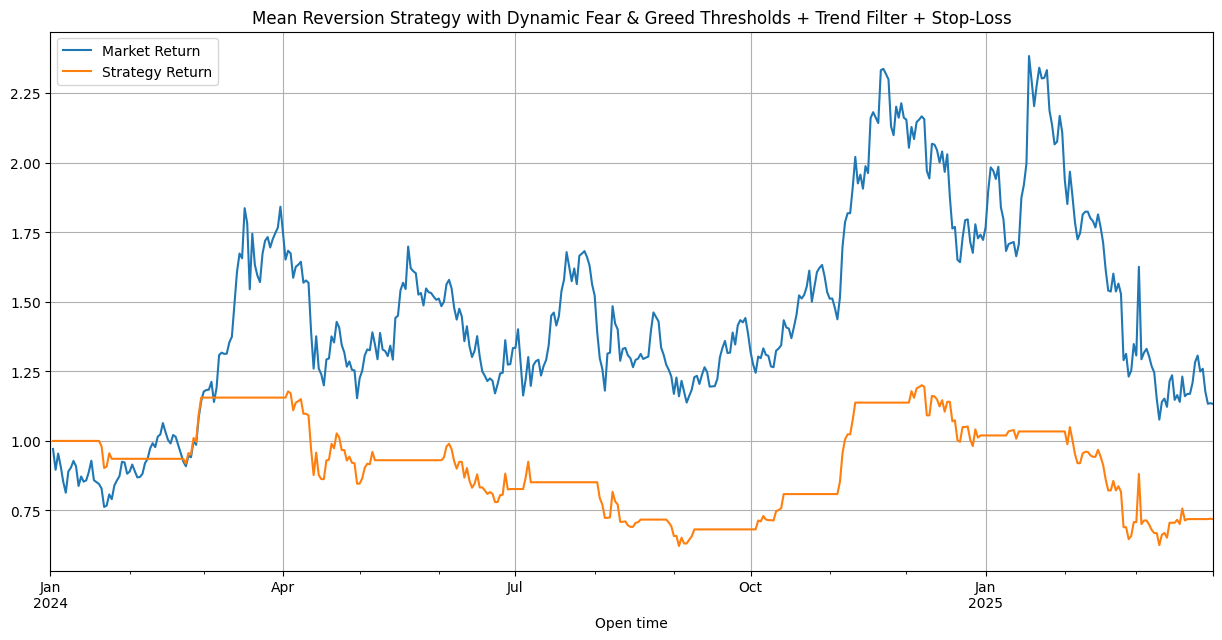

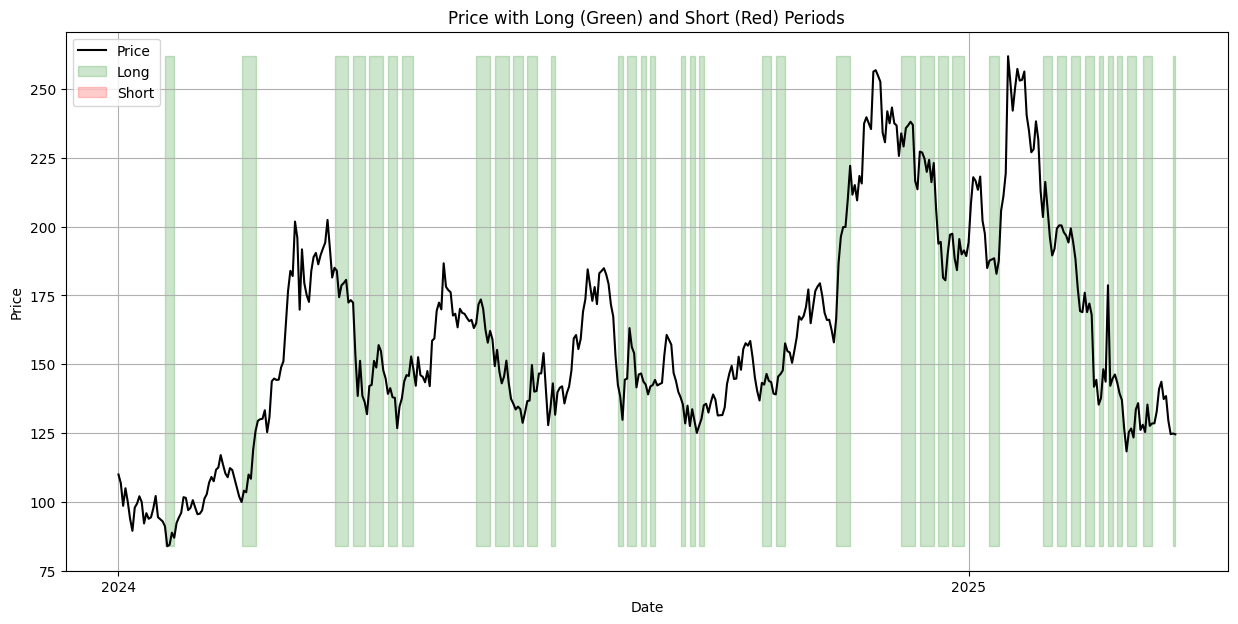

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# ==============================
# Parameters (Easy to Calibrate)
# ==============================
window = 20                 # Rolling window for mean and std
fear_threshold_low = 30     # Fear threshold (low)
greed_threshold_high = 70   # Greed threshold (high)

threshold_fear = 0.5       # Entry Z-threshold under fear
threshold_neutral = 0.75     # Entry Z-threshold neutral
threshold_greed = 0.5       # Entry Z-threshold under greed

exit_days_fear = 3          # Max holding days under fear
exit_days_neutral = 5       # Max holding days under neutral
exit_days_greed = 7         # Max holding days under greed

max_loss_cut = 100         # Stop-loss cut-off (e.g., -3%)
trend_filter_window = 20   # Moving average window for trend filter (to only short below MA)
use_trend_filter = True     # Whether to use trend filter
# ==============================

# Load your dataframe
price = df['Close']

# Calculate moving average and std
moving_avg = price.rolling(window=window).mean()
moving_std = price.rolling(window=window).std()

# Calculate z-score
z_score = (price - moving_avg) / moving_std

# Trend filter (long-term trend detection)
trend_ma = price.rolling(window=trend_filter_window).mean()

# Initialize
position = []
current_position = 0
days_in_position = 0
entry_price = 0  # Track the price where you entered

# Loop through each day
for i in range(len(df)):
    today_fear_greed = df['F&G'].iloc[i]
    today_price = df['Close'].iloc[i]
    today_z = z_score.iloc[i]
    
    # Set dynamic threshold and exit period
    if today_fear_greed < fear_threshold_low:
        threshold = threshold_fear
        exit_after_days = exit_days_fear
    elif today_fear_greed > greed_threshold_high:
        threshold = threshold_greed
        exit_after_days = exit_days_greed
    else:
        threshold = threshold_neutral
        exit_after_days = exit_days_neutral

    # Skip if z_score is NaN (early period)
    if pd.isna(today_z):
        position.append(0)
        continue

    # Trading logic
    if current_position == 0:  # Not in trade
        if today_z < -threshold:
            current_position = 1  # Long
            days_in_position = 1
            entry_price = today_price
        elif today_z > threshold:
            # Trend filter: Only short if under trend moving average
            if (not use_trend_filter) or (today_price < trend_ma.iloc[i]):
                current_position = -1  # Short
                days_in_position = 1
                entry_price = today_price
            else:
                current_position = 0
    else:  # Already in a trade
        days_in_position += 1

        # Stop-loss check
        if current_position == 1 and (today_price < entry_price * (1 - max_loss_cut)):
            current_position = 0
            days_in_position = 0
        elif current_position == -1 and (today_price > entry_price * (1 + max_loss_cut)):
            current_position = 0
            days_in_position = 0
        elif days_in_position > exit_after_days:
            current_position = 0
            days_in_position = 0

    position.append(current_position)

# Add Position to dataframe
df['Position'] = position

# Shift to avoid lookahead bias
df['Position'] = df['Position'].shift(1)

# Calculate returns
df['Market Return'] = df['Close'].pct_change()
df['Strategy Return'] = df['Position'] * df['Market Return']

# Plot cumulative returns
(1 + df[['Market Return', 'Strategy Return']]).cumprod().plot(figsize=(15,7))
plt.title('Mean Reversion Strategy with Dynamic Fear & Greed Thresholds + Trend Filter + Stop-Loss')
plt.grid(True)
plt.show()

# Plotting price with long/short zones
fig, ax = plt.subplots(figsize=(15,7))

# Plot the price
ax.plot(df.index, price, label='Price', color='black')

# Shade LONG periods
long_periods = df['Position'] == 1
ax.fill_between(df.index, price.min(), price.max(), 
                where=long_periods, color='green', alpha=0.2, label='Long')

# Shade SHORT periods
short_periods = df['Position'] == -1
ax.fill_between(df.index, price.min(), price.max(), 
                where=short_periods, color='red', alpha=0.2, label='Short')

# Formatting
ax.set_title('Price with Long (Green) and Short (Red) Periods')
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend()
ax.grid(True)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

plt.show()



In [29]:
df["Position"].sum()

np.float64(181.0)

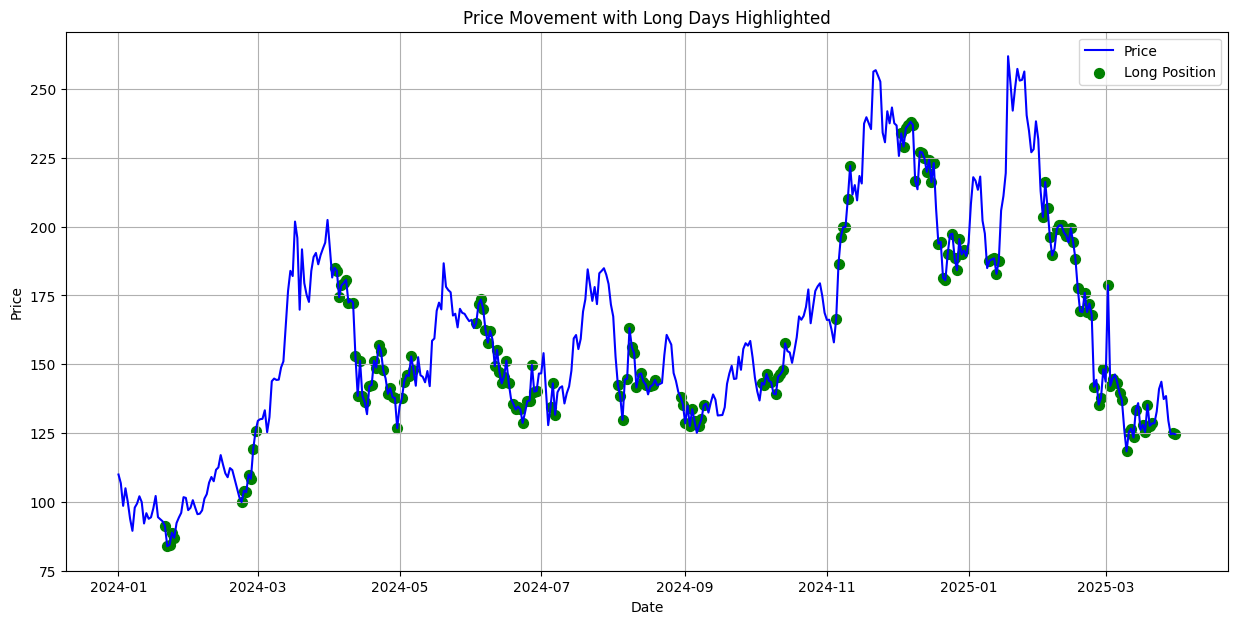

In [30]:
import matplotlib.pyplot as plt

# Plot setup
plt.figure(figsize=(15,7))

# Plot price
plt.plot(df.index, df['Close'], label='Price', color='blue')

# Highlight long days
long_days = df['Position'] == 1
plt.scatter(df.index[long_days], df['Close'][long_days], 
            label='Long Position', color='green', marker='o', s=50)

# Titles and labels
plt.title('Price Movement with Long Days Highlighted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


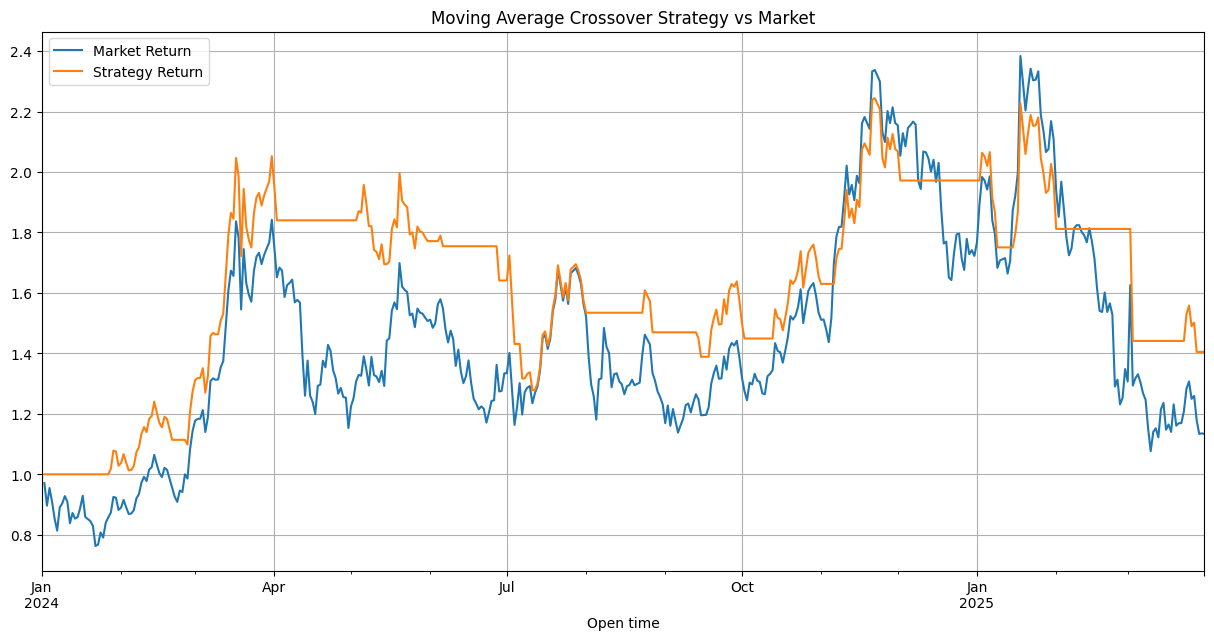

In [31]:
price = df['Close']

# Calculate Moving Average
window = 20  # e.g., 50 days
sma = price.rolling(window=window).mean()

# Trading signals
df['Position'] = 0
df['SMA'] = sma

# Buy signal: price crosses above SMA
df.loc[price > sma, 'Position'] = 1

# Sell signal: price crosses below SMA
df.loc[price <= sma, 'Position'] = 0

# Shift position for returns
df['Position'] = df['Position'].shift(1)

# Returns
df['Market Return'] = price.pct_change()
df['Strategy Return'] = df['Position'] * df['Market Return']

# Plot cumulative returns
(1 + df[['Market Return', 'Strategy Return']]).cumprod().plot(figsize=(15,7))
plt.title('Moving Average Crossover Strategy vs Market')
plt.grid(True)
plt.show()

